In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import model.sdes as sdes
import model.generate as generate
import model.graph_net as graph_net
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import networkx as nx
import tqdm.notebook
import rdkit
import IPython

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0]
branch_defs = [((0,), 0, 1)]

In [4]:
dataset = molecule_dataset.ZINCDataset()

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
class VarianceExplodingSDE(sdes.SDE):
    
    def __init__(self, sigma_min, sigma_max, input_shape, symmetrize=False):
        super().__init__(input_shape)
        
        self.sigma_min = torch.tensor(sigma_min).to(DEVICE)
        self.sigma_max = torch.tensor(sigma_max).to(DEVICE)
        self.symmetrize = symmetrize
        if symmetrize:
            assert len(input_shape) == 2 and input_shape[0] == input_shape[1]
        
    def drift_coef_func(self, xt, t):
        return torch.zeros_like(xt)
    
    def diff_coef_func(self, xt, t):
        return self._inflate_dims(
            self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t) *
            torch.sqrt(2 * torch.log(self.sigma_max / self.sigma_min))
        )

    def forward(self, x0, t, return_score=True):
        z = torch.normal(torch.zeros_like(x0), torch.ones_like(x0))
        if self.symmetrize:
            z = torch.triu(z, diagonal=1)
            z = z + torch.transpose(z, 1, 2)
        std = self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t)
        std = self._inflate_dims(std)
        xt = x0 + (std * z)
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        
    def mean_score_mag(self, t):
        variance = torch.square(self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t))
        return 1 / variance
        
    def sample_prior(self, num_sample, t):
        shape = torch.Size([num_sample]) + torch.Size(self.input_shape)
        z = torch.normal(torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE))
        if self.symmetrize:
            z = torch.triu(z, diagonal=1)
            z = z + torch.transpose(z, 1, 2)
        std = self.sigma_min * torch.pow(self.sigma_max / self.sigma_min, t)
        return z * self._inflate_dims(std)

class VariancePreservingSDE(sdes.SDE):
    
    def __init__(self, beta_0, beta_1, input_shape, symmetrize=False):
        super().__init__(input_shape)
        
        self.beta_0 = torch.tensor(beta_0).to(DEVICE)
        self.delta_beta = torch.tensor(beta_1 - beta_0).to(DEVICE)
        self.symmetrize = symmetrize
        if symmetrize:
            assert len(input_shape) == 2 and input_shape[0] == input_shape[1]

    def _beta(self, t):
        return self.beta_0 + (self.delta_beta * t)
        
    def _beta_bar(self, t):
        return (self.beta_0 * t) + (0.5 * self.delta_beta * torch.square(t))
    
    def drift_coef_func(self, xt, t):
        return -0.5 * self._inflate_dims(self._beta(t)) * xt
    
    def diff_coef_func(self, xt, t):
        return self._inflate_dims(torch.sqrt(self._beta(t)))
    
    def forward(self, x0, t, return_score=True):
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        if self.symmetrize:
            z = torch.triu(z, diagonal=1)
            z = z + torch.transpose(z, 1, 2)
        
        mean = x0 * torch.exp(-0.5 * self._inflate_dims(self._beta_bar(t)))
        variance = 1 - torch.exp(-self._beta_bar(t))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...
        
        xt = mean + (std * z)
        
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        
    def mean_score_mag(self, t):
        variance = 1 - torch.exp(-self._beta_bar(t))
        return 1 / variance  # Shape: B
        
    def sample_prior(self, num_samples, t):
        # We will sample in the limit as t approaches infinity
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        z = torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE),
            generator=self.rng
        )  # Shape: B x ...
        if self.symmetrize:
            z = torch.triu(z, diagonal=1)
            z = z + torch.transpose(z, 1, 2)
        return z

class AXJointSDE(sdes.SDE):
    
    def __init__(self, vp_beta_0, vp_beta_1, ve_sigma_min, ve_sigma_max, input_shape):
        super().__init__(input_shape)
        
        self.adj_shape = (input_shape[0], input_shape[0])
        self.x_shape = (input_shape[0], input_shape[1] - input_shape[0])
        
        self.adj_sde = VarianceExplodingSDE(ve_sigma_min, ve_sigma_max, self.adj_shape, symmetrize=True)
        self.x_sde = VariancePreservingSDE(vp_beta_0, vp_beta_1, self.x_shape)
        
    def forward(self, x0, t, return_score=True):
        adj_x0, x_x0 = x0[:, :, :x0.shape[1]], x0[:, :, x0.shape[1]:]
        if return_score:
            adj_xt, adj_score = self.adj_sde.forward(adj_x0, t, True)
            x_xt, x_score = self.x_sde.forward(x_x0, t, True)
            xt = torch.cat([adj_xt, x_xt], dim=2)
            score = torch.cat([adj_score, x_score], dim=2)
            return xt, score
        else:
            adj_xt = self.adj_sde.forward(adj_x0, t, False)
            x_xt = self.x_sde.forward(x_x0, t, False)
            return torch.cat([adj_xt, x_xt], dim=2)
        
    def mean_score_mag(self, t):
        adj_mag = self._inflate_dims(self.adj_sde.mean_score_mag(t))
        x_mag = self._inflate_dims(self.x_sde.mean_score_mag(t))
        adj_mag = torch.tile(adj_mag, (1,) + self.adj_shape)
        x_mag = torch.tile(x_mag, (1,) + self.x_shape)
        return torch.cat([adj_mag, x_mag], dim=2)
        
    def sample_prior(self, num_samples, t):
        adj_prior = self.adj_sde.sample_prior(num_samples, t)
        x_prior = self.x_sde.sample_prior(num_samples, t)
        return torch.cat([adj_prior, x_prior], dim=2)

In [7]:
# Create the SDE and model
sde = AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

model = graph_net.GraphJointNetwork(len(branch_defs), t_limit).to(DEVICE)

MODEL_DIR = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_nobranch"

### Show the forward-diffusion process

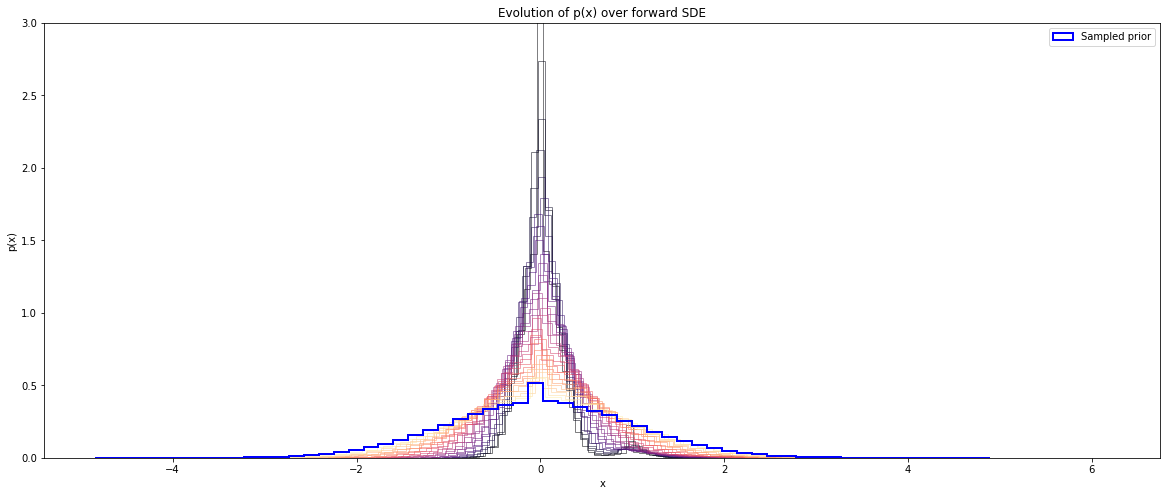

In [8]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [9]:
def train_model(
    model, sde, data_loader, model_type, class_mapper, num_epochs,
    learning_rate, loss_weighting_type="empirical_norm",
    weight_func=None, t_limit=1
):
    assert model_type in ("branched", "labelguided")
    
    run_num = max([int(x) for x in os.listdir(MODEL_DIR) if x.isdigit()]) + 1
    print(run_num)
    output_dir = os.path.join(MODEL_DIR, str(run_num))
    os.makedirs(output_dir)

    model.train()
    torch.set_grad_enabled(True)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(num_epochs):
        batch_losses = []
        t_iter = tqdm.notebook.tqdm(data_loader)
        for x0, y in t_iter:
            x0 = x0.to(DEVICE).float()
            
            # NEW: Get node "flags" to mask out parts that overrun molecule boundaries
            adj_x0 = x0[:, :, :x0.shape[1]]
            node_flags = graph_net.node_flags(adj_x0)
            
            # Sample random times from 0 to 1
            t = (torch.rand(x0.shape[0]) * t_limit).to(DEVICE)
    
            # Run SDE forward to get xt and the true score at xt
            xt, true_score = sde.forward(x0, t)
            
            # NEW: Mask out overrunning parts of xt and true score
            adj_xt, x_xt = xt[:, :, :xt.shape[1]], xt[:, :, xt.shape[1]:]
            adj_xt = graph_net.mask_adjs(adj_xt, node_flags)
            x_xt = graph_net.mask_x(x_xt, node_flags)
            xt = torch.cat([adj_xt, x_xt], dim=2)
            adj_true_score, x_true_score = \
                true_score[:, :, :true_score.shape[1]], true_score[:, :, true_score.shape[1]:]
            adj_true_score = graph_net.mask_adjs(adj_true_score, node_flags)
            x_true_score = graph_net.mask_x(x_true_score, node_flags)
            true_score = torch.cat([adj_true_score, x_true_score], dim=2)
            
            # Get model-predicted score
            # NEW: include node flags so predicted score masks out overruns
            if model_type == "branched":
                pred_score = model(xt, t, node_flags)
            else:
                class_inds = class_mapper(y).long()
                pred_score = model(xt, t, node_flags, class_inds)
            
            # Get weighting factor
            if loss_weighting_type == "ml":
                loss_weight = 1 / sde.diff_coef_func(xt, t)
            elif loss_weighting_type == "expected_norm":
                loss_weight = sde._inflate_dims(sde.mean_score_mag(t))
            elif loss_weighting_type == "empirical_norm":
                loss_weight = sde._inflate_dims(torch.mean(
                    torch.square(true_score), dim=tuple(range(1, len(x0.shape)))
                ))
            elif loss_weighting_type is None:
                loss_weight = torch.ones_like(x0)

            if weight_func is not None:
                # Division here, as `loss_weight` itself is the divisor
                extra_weights = weight_func(x0)
                loss_weight = loss_weight / extra_weights

            # Compute loss
            if model_type == "branched":
                # Compute branch indices
                branch_inds = class_mapper(y, t)
                loss = model.loss(
                    pred_score, true_score, branch_inds, loss_weight
                )
            else:
                loss = model.loss(pred_score, true_score, loss_weight)
            loss_val = loss.item()
            t_iter.set_description("Loss: %.2f" % loss_val)

            if not np.isfinite(loss_val):
                continue

            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optim.step()
            
            batch_losses.append(loss_val)
        
        epoch_loss = np.mean(batch_losses)
        print("Epoch %d average Loss: %.2f" % (epoch_num + 1, epoch_loss))
        
        model_path = os.path.join(
            output_dir, "epoch_%d_ckpt.pth" % (epoch_num + 1)
        )
        link_path = os.path.join(output_dir, "last_ckpt.pth")

        # Save model
        model_util.save_model(model, model_path)

        # Create symlink to last epoch
        if os.path.islink(link_path):
            os.remove(link_path)
        os.symlink(os.path.basename(model_path), link_path)

In [10]:
# train_model(
#     model, sde, data_loader, "branched", class_time_to_branch_tensor, 50,
#     1e-3, loss_weighting_type="empirical_norm", t_limit=t_limit
# )

In [11]:
model = model_util.load_model(
    graph_net.GraphJointNetwork,
    "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_nobranch/9/last_ckpt.pth"
).to(DEVICE)

### Show generated distributions

In [12]:
def generate_continuous_samples(
    model, sde, class_to_sample, model_type, class_mapper, node_flags,
    num_samples=64, num_steps=500, t_start=0.001, t_limit=1,
    initial_samples=None, verbose=False
):
    assert model_type in ("branched", "labelguided")

    # First, sample from the prior distribution at some late time t
    if initial_samples is not None:
        xt = initial_samples
    else:
        t = (torch.ones(num_samples) * t_limit).to(DEVICE)
        xt = sde.sample_prior(num_samples, t)
        
    # NEW: mask out overrun
    adj_xt, x_xt = xt[:, :, :xt.shape[1]], xt[:, :, xt.shape[1]:]
    adj_xt = graph_net.mask_adjs(adj_xt, node_flags)
    x_xt = graph_net.mask_x(x_xt, node_flags)
    xt = torch.cat([adj_xt, x_xt], dim=2)

    if model_type == "branched":
        class_tens = torch.tensor([class_to_sample], device=DEVICE)
    else:
        class_tens = torch.tile(
            torch.tensor([class_to_sample], device=DEVICE), (num_samples,)
        )
    
    # Disable gradient computation in model
    torch.set_grad_enabled(False)
    
    time_steps = torch.linspace(t_limit, t_start, num_steps).to(DEVICE)
    # (descending order)
    step_size = time_steps[0] - time_steps[1]

    # Step backward through time starting at xt
    x = xt
    t_iter = tqdm.tqdm(time_steps) if verbose else time_steps
    for time_step in t_iter:
        t = torch.ones(num_samples).to(DEVICE) * time_step\

        # Take Langevin MCMC step
        # NEW: include node flags so predicted score masks out overruns
        if model_type == "branched":
            branch_index = class_mapper(class_tens, time_step[None])[0]
            score = model(x, t, node_flags, [branch_index])[:, 0]
        else:
            class_index = class_mapper(class_tens).long()
            score = model(x, t, node_flags, class_index)

        snr = 0.1
        score_norm = torch.mean(
            torch.norm(score.reshape(score.shape[0], -1), dim=-1)
        )
        alpha = snr * (
            torch.prod(torch.tensor(x.shape[1:])) / torch.square(score_norm)
        )

        z = torch.randn_like(x)
        # NEW: symmetrize noise and mask out overrun
        adj_z, x_z = z[:, :, :z.shape[1]], z[:, :, z.shape[1]:]
        adj_z = graph_net.mask_adjs(adj_z, node_flags)
        adj_z = torch.triu(adj_z, diagonal=1)
        adj_z = adj_z + torch.transpose(adj_z, 1, 2)
        x_z = graph_net.mask_x(x_z, node_flags)
        z = torch.cat([adj_z, x_z], dim=2)
        
        x = x + ((alpha / 2) * score) + \
            (torch.sqrt(alpha) * z)

        # Take SDE step
        f = sde.drift_coef_func(x, t)
        g = sde.diff_coef_func(x, t)
        dw = torch.randn_like(x)
        # NEW: symmetrize noise and mask out overrun
        adj_dw, x_dw = dw[:, :, :dw.shape[1]], dw[:, :, dw.shape[1]:]
        adj_dw = graph_net.mask_adjs(adj_dw, node_flags)
        adj_dw = torch.triu(adj_dw, diagonal=1)
        adj_dw = adj_dw + torch.transpose(adj_dw, 1, 2)
        x_dw = graph_net.mask_x(x_dw, node_flags)
        dw = torch.cat([adj_dw, x_dw], dim=2)

        # NEW: include node flags so predicted score masks out overruns
        if model_type == "branched":
            score = model(x, t, node_flags, [branch_index])[:, 0]
        else:
            score = model(x, t, node_flags, class_index)

        drift = (f - (torch.square(g) * score)) * step_size
        diff = g * torch.sqrt(step_size) * dw

        mean_x = x - drift  # Subtract because step size is really negative
        x = mean_x + diff
        
    return mean_x  # Last step: don't include the diffusion/randomized term

In [13]:
samples = {}
num_samples_per_class = 64
for class_to_sample in classes:
    # Sample some initial node flags
    inds = np.random.choice(np.where(dataset.target == class_to_sample)[0], size=num_samples_per_class, replace=True)
    batch = torch.stack([dataset[i][0] for i in inds], dim=0)
    adj = batch[:, :, :batch.shape[1]]
    sampled_flags = graph_net.node_flags(adj)
    
    sample = generate_continuous_samples(
        model, sde, class_to_sample, "branched", class_time_to_branch_tensor,
        sampled_flags, num_samples=num_samples_per_class, t_limit=t_limit,
        num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.28it/s]


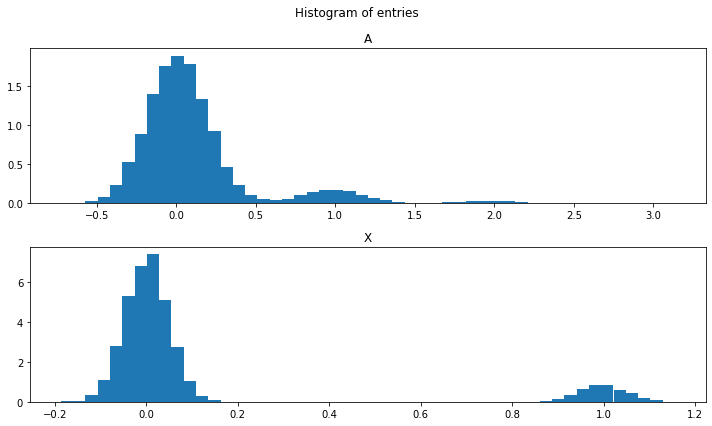

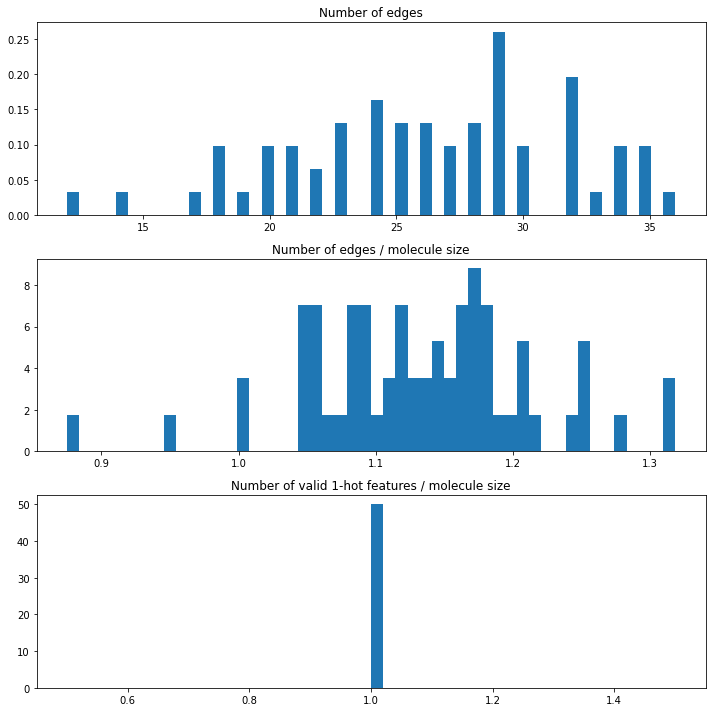

In [14]:
samps = np.concatenate(list(samples.values()), axis=0)
adjs, xs = samps[:, :, :samps.shape[1]], samps[:, :, samps.shape[1]:]
    
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
ax[0].hist(np.ravel(adjs[adjs != 0]), bins=50, density=True)
ax[1].hist(np.ravel(xs[xs != 0]), bins=50, density=True)
ax[0].set_title("A")
ax[1].set_title("X")
fig.suptitle("Histogram of entries")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))
sizes = np.sum(np.sum(xs, axis=2) > 0, axis=1)
ax[0].hist((np.sum(adjs > 0.5, axis=(1, 2)) / 2), bins=50, density=True)
ax[1].hist((np.sum(adjs > 0.5, axis=(1, 2)) / 2) / sizes, bins=50, density=True)
ax[2].hist(np.sum(np.sum(xs > 0.5, axis=2) == 1, axis=1) / sizes, bins=50, density=True)
ax[0].set_title("Number of edges")
ax[1].set_title("Number of edges / molecule size")
ax[2].set_title("Number of valid 1-hot features / molecule size")
fig.tight_layout()
plt.show()

In [15]:
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]
BOND_TYPES = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def samples_to_rdkmols(adj, x, flags):
    """
    Given a B x M x M adjacency matrix batch and B x M x D node feature
    batch, and a B x M binary array of flags (all NumPy arrays),
    converts them to RDKit molecule objects.
    """
    mol_sizes = np.sum(flags, axis=1)
    atomic_nums = np.argmax(x, axis=2)
    
    mols = []
    for i in range(len(adj)):
        size = mol_sizes[i]
        a, atoms = adj[i][:size][:, :size], atomic_nums[i][:size]
        mol = rdkit.Chem.RWMol()
        
        for atom in atoms:
            mol.AddAtom(rdkit.Chem.Atom(ATOM_SYMBOLS[atom]))
            
        for u, v in zip(*np.nonzero(np.triu(a, k=1))):
            mol.AddBond(int(u), int(v), BOND_TYPES[a[u, v] - 1])
            
        mols.append(mol)
    return mols

In [16]:
# Convert to molecule objects
mol_samples = {}
for class_to_sample in classes:
    samps = samples[class_to_sample]
    s = samps.shape[1]
    adj, x = samps[:, :, :s], samps[:, :, s:]
    
    # Discretize
    adj[adj < 0.5] = 0
    adj[(adj >= 0.5) & (adj < 1.5)] = 1
    adj[(adj >= 1.5) & (adj < 2.5)] = 2
    adj[adj >= 2.5] = 3
    adj = np.triu(adj, k=1)
    adj = adj + np.swapaxes(adj, 1, 2)
    x[x < 0.5] = 0
    x[x >= 0.5] = 1
    adj, x = adj.astype(int), x.astype(int)
    
    # Convert
    mol_samples[class_to_sample] = samples_to_rdkmols(adj, x, sampled_flags.cpu().numpy().astype(int))

In [17]:
def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

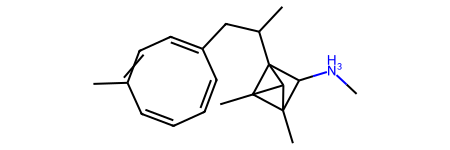

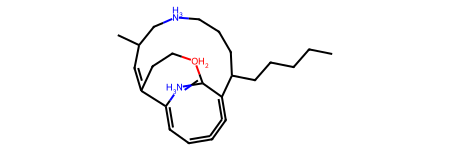

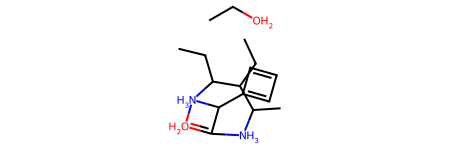

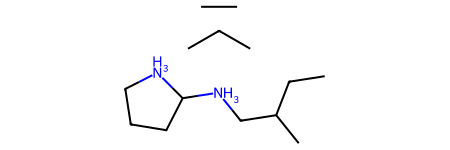

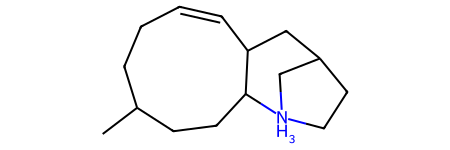

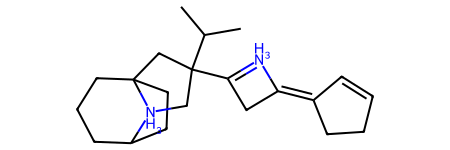

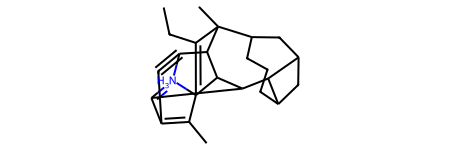

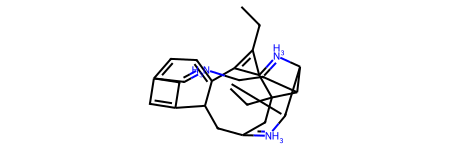

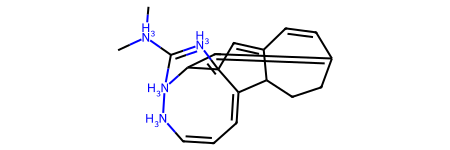

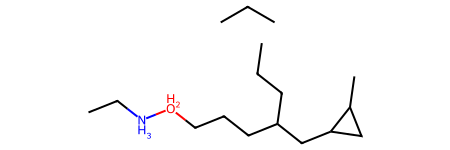

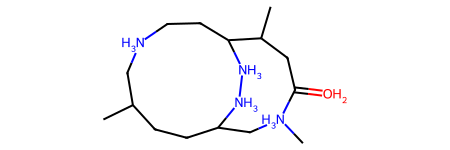

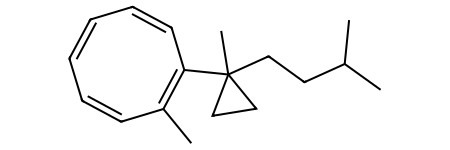

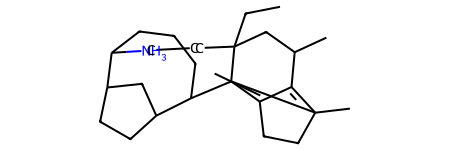

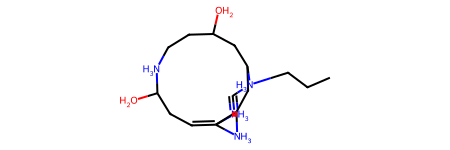

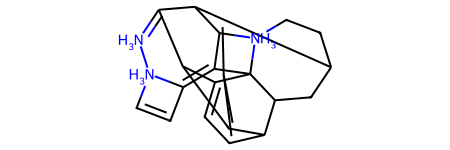

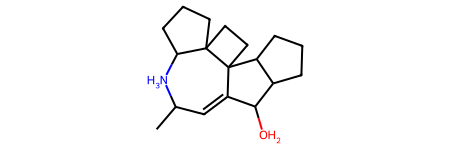

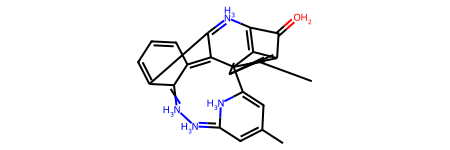

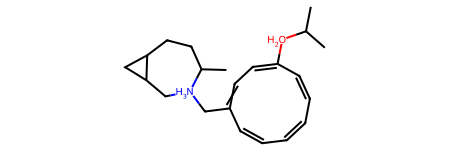

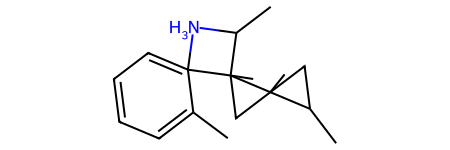

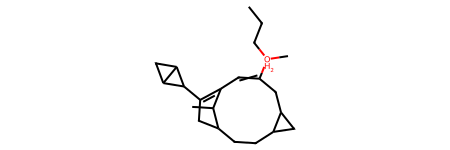

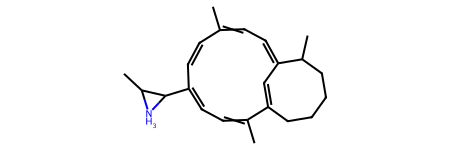

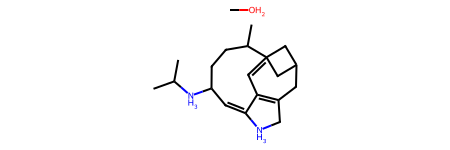

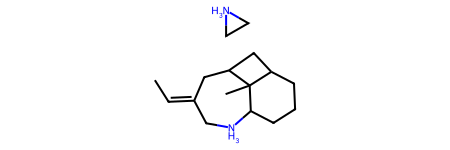

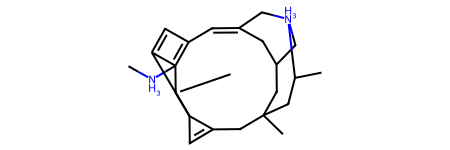

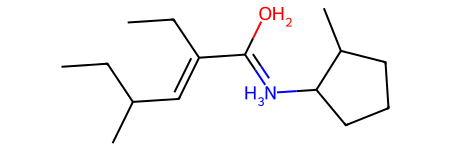

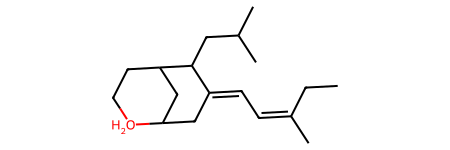

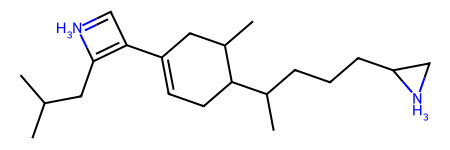

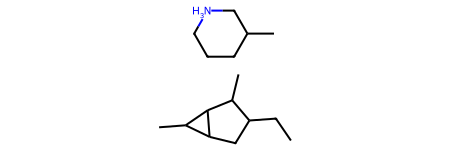

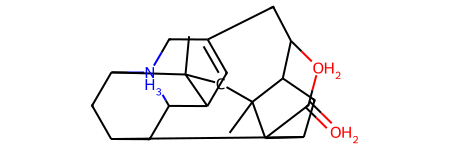

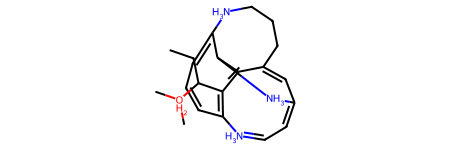

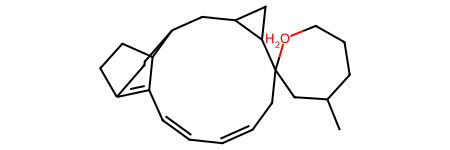

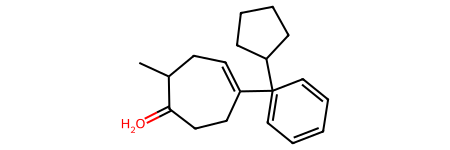

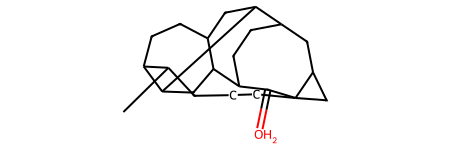

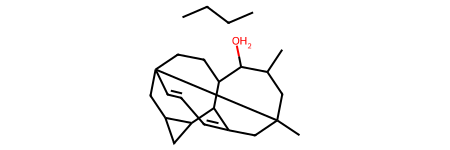

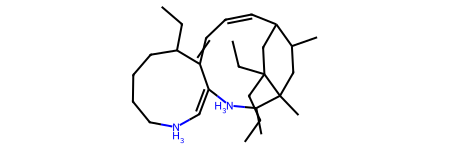

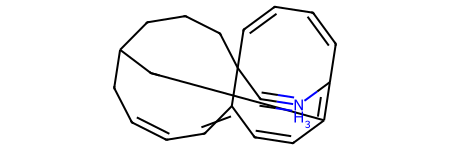

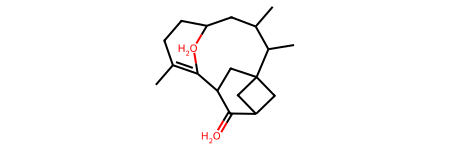

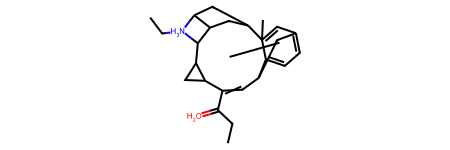

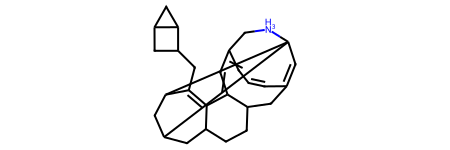

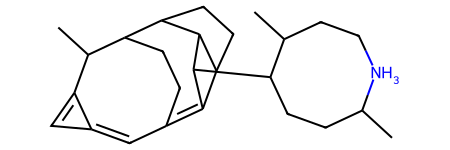

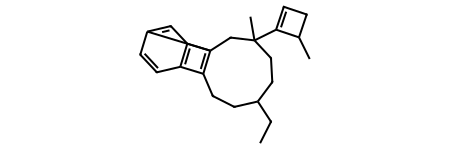

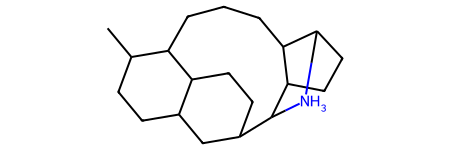

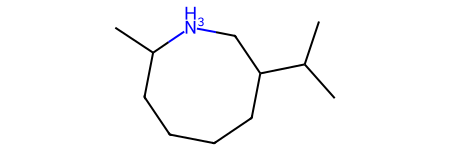

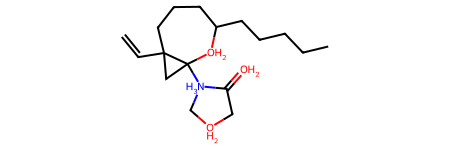

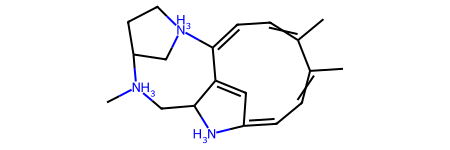

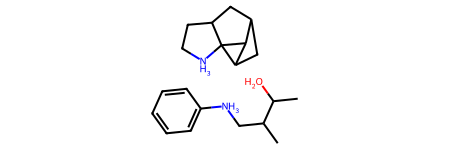

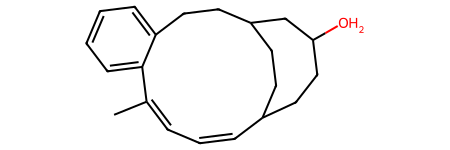

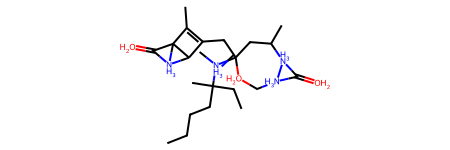

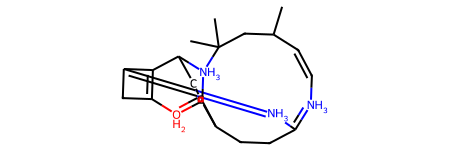

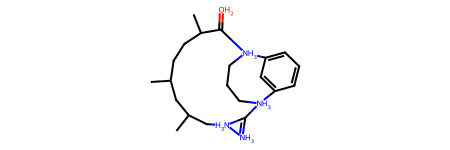

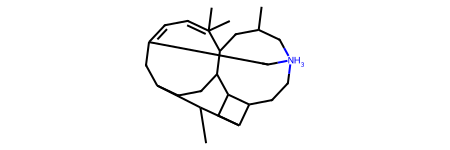

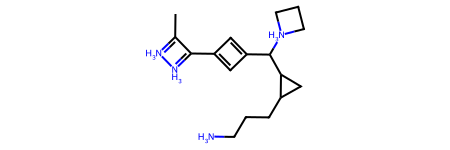

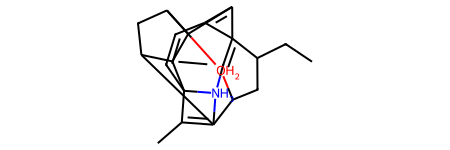

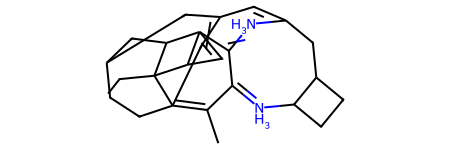

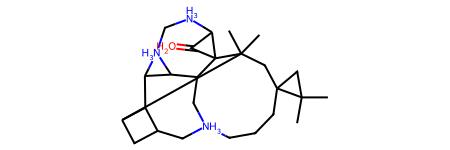

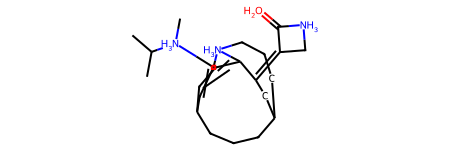

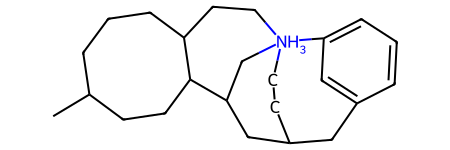

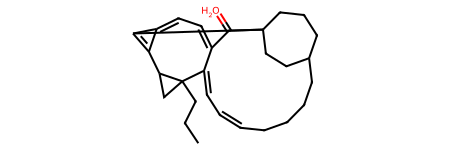

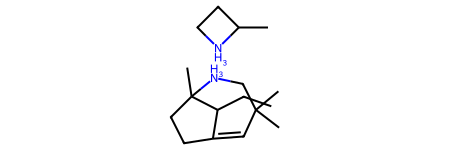

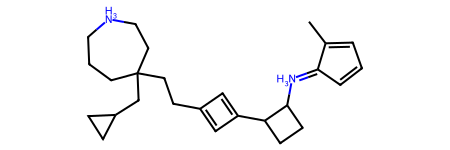

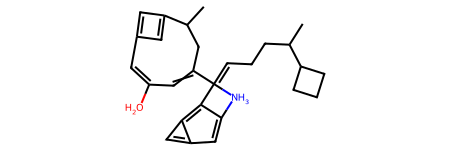

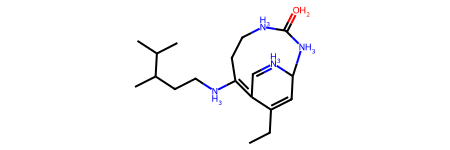

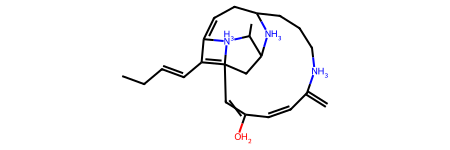

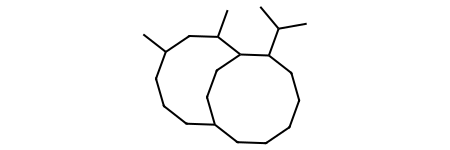

In [18]:
for class_to_sample in classes:
    for mol in mol_samples[class_to_sample]:
        IPython.display.display(plot_molecule(mol))